In [1]:
# rtdatacentric52 rerun of rtdatacentric46
# changed number of images augmented

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator


In [3]:
import cv2
import numpy as np
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

from PIL import Image
import pathlib
import shutil

In [4]:
print(tf.__version__)

2.4.1


In [5]:
batch_size = 8
img_height = 32
img_width = 32
tf.random.set_seed(123)
data_set = 'rtdatacentric57'

train_dir = os.path.join(data_set,'train')
val_dir = os.path.join(data_set,'val')
all_dir = os.path.join(data_set,'all')
test_dir = os.path.join(data_set,'test')
aug_dir = os.path.join(data_set,'aug')
add_dir = os.path.join(data_set,'add')
data_dir = pathlib.Path(os.path.join(all_dir))


In [6]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

image_count = len(list(data_dir.glob('*/*.png')))
print(f"all: { image_count} ")

train_data_dir = pathlib.Path(os.path.join(train_dir))
train_image_count = len(list(train_data_dir.glob('*/*.png')))
print(f"train: { train_image_count} ")

val_data_dir = pathlib.Path(os.path.join(val_dir))
val_image_count = len(list(val_data_dir.glob('*/*.png')))
print(f"val: { val_image_count} ")

test_data_dir = pathlib.Path(os.path.join(test_dir))
test_image_count = len(list(test_data_dir.glob('*/*.png')))
print(f"test: { test_image_count} ")


['i' 'ii' 'iii' 'iv' 'ix' 'v' 'vi' 'vii' 'viii' 'x']
all: 1809 
train: 8169 
val: 466 
test: 52 


In [7]:
def clear_dir(target_dir):
    # clear all images in train and val directories
    for rn in class_names:
        dir = os.path.join(target_dir, rn)
        for f in os.listdir(dir):
            path = os.path.join(dir, f)
            try:
                shutil.rmtree(path)
            except OSError:
                os.remove(path)
       


In [8]:
clear_dir(train_data_dir)

clear_dir(val_data_dir)

In [9]:
val_percent =.25

In [10]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.png'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)


In [11]:
val_size = int(image_count * val_percent)
if val_percent > 0.0:
    train_ds = list_ds.skip(val_size)
    val_ds = list_ds.take(val_size)
else: 
    val_image_count = len(list(val_data_dir.glob('*/*.png')))
    print(val_image_count)
    val_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*.png'), shuffle=True)
    val_ds = val_ds.shuffle(val_image_count, reshuffle_each_iteration=True)
    train_ds = list_ds.skip(val_size)
    

In [12]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


1357
452


In [13]:
for rom_num in class_names:
    images_path = os.path.join(train_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")
    

i : 0
ii : 0
iii : 0
iv : 0
ix : 0
v : 0
vi : 0
vii : 0
viii : 0
x : 0


In [14]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label, file_path

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
trainimg = {}
valimg = {}

In [18]:
# put training images into a directory
for image, label, file_path in train_ds:
    basename = os.path.basename(file_path.numpy())
    cur_class_name = os.path.join(class_names[label.numpy()])
    class_name_path = os.path.join(cur_class_name)
    newfile_dir = os.path.join(train_dir,class_name_path)
    newfile_path = os.path.join(newfile_dir, basename.decode('utf-8'))
    
    trainimg[basename.decode('utf-8')] = cur_class_name

In [19]:
if val_percent > 0.0:
    # put validation images into a directory
    for image, label, file_path in val_ds:
        basename = os.path.basename(file_path.numpy())
        cur_class_name = os.path.join(class_names[label.numpy()])
        class_name_path = os.path.join(cur_class_name)
        newfile_dir = os.path.join(val_dir,class_name_path)
        newfile_path = os.path.join(newfile_dir, basename.decode('utf-8'))
    
        valimg[basename.decode('utf-8')] = cur_class_name

In [20]:
# put images into their respective dirs
dirall = data_dir
for itname in trainimg:
    src = os.path.join(dirall, trainimg[itname], itname)
    dest = os.path.join(train_dir, trainimg[itname],itname)
    shutil.copy(src, dest)
print("Images copied into train")

if val_percent > 0.0:
    for iname in valimg:
        src = os.path.join(dirall, valimg[iname], iname)
        dest = os.path.join(val_dir,valimg[iname],iname)
        shutil.copy(src, dest)
    print("Images copied into val")

Images copied into train
Images copied into val


In [21]:

for rom_num in class_names:
    images_path = os.path.join(train_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")

i : 162
ii : 143
iii : 106
iv : 192
ix : 147
v : 143
vi : 113
vii : 114
viii : 114
x : 123


In [22]:
# Data augmentation settings
# datagen = ImageDataGenerator(
#    rotation_range=10, 
#    width_shift_range=0.1, 
#    height_shift_range=0.1,
#    shear_range=0.15, 
#    zoom_range=0.1,
#    channel_shift_range = 10, 
#    horizontal_flip=False
#)

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=5,
                             zoom_range=0.1,
                             cval=0.0,)

# numeral_multiplier =[2, 4, 4, 3, 3, 3, 3, 3, 4, 2]
numeral_multiplier =[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [23]:
# Data augmentation create images
save_here = aug_dir
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
class_numeral = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']
numeral_number_images = []
numeral_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for numeral in class_names:
    array_index = class_numeral.index(numeral)
    # path to original images
    images_path=os.path.join(train_dir,numeral) 
    print(f"images_path = { images_path }")
    num_range = numeral_multiplier[class_numeral.index(numeral)]
    print(f"multiplier = { num_range }")
    # path to store aumented images
    augmented_path=os.path.join(aug_dir,numeral) 
    # path to store aumented images
    images=[] 
    # to store paths of images from folder
    for image in os.listdir(images_path): 
        image_path = os.path.join(images_path, image)
        image = np.expand_dims(cv2.imread(image_path), 0)
        datagen.fit(image)
        for x, val in zip(datagen.flow(image,                    #image we chose
            save_to_dir=os.path.join(train_dir,numeral),     #this is where we figure out where to save
            save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
            save_format='png'),range(num_range)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
                pass

images_path = rtdatacentric57/train/i
multiplier = 4
images_path = rtdatacentric57/train/ii
multiplier = 4
images_path = rtdatacentric57/train/iii
multiplier = 4
images_path = rtdatacentric57/train/iv
multiplier = 4
images_path = rtdatacentric57/train/ix
multiplier = 4
images_path = rtdatacentric57/train/v
multiplier = 4
images_path = rtdatacentric57/train/vi
multiplier = 4
images_path = rtdatacentric57/train/vii
multiplier = 4
images_path = rtdatacentric57/train/viii
multiplier = 4
images_path = rtdatacentric57/train/x
multiplier = 4


In [24]:
for rom_num in class_names:
    images_path = os.path.join(train_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")

i : 939
ii : 829
iii : 624
iv : 1104
ix : 854
v : 831
vi : 661
vii : 665
viii : 666
x : 724


In [25]:
#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,20)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,20)
    return rotate(image, -angle)

def h_flip(image):
    return np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (9,9),0)
    #I would not recommend warp_shifting, because it distorts image, but can be␣used in many use case like
    #classifying blur and non-blur images

def warp_shift(image):
    # chose x,y values according to your convinience
    transform = AffineTransform(translation=(0,40)) 
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [26]:
for rom_num in class_names:
    images_path = os.path.join(train_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")
for rom_num in class_names:
    images_path = os.path.join(val_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")
    

i : 939
ii : 829
iii : 624
iv : 1104
ix : 854
v : 831
vi : 661
vii : 665
viii : 666
x : 724
i : 65
ii : 41
iii : 31
iv : 62
ix : 48
v : 48
vi : 35
vii : 48
viii : 35
x : 39


In [27]:
class_numeral = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

In [28]:
for rom_num in class_names:
    images_path = os.path.join(train_dir, rom_num)
    print(f"{rom_num} : {len(os.listdir(images_path))}")
    

i : 939
ii : 829
iii : 624
iv : 1104
ix : 854
v : 831
vi : 661
vii : 665
viii : 666
x : 724


In [29]:
# check total number of images
train_data_dir = pathlib.Path(os.path.join(train_dir))
train_image_count = len(list(train_data_dir.glob('*/*.*g')))
print(train_image_count)

val_data_dir = pathlib.Path(os.path.join(val_dir))
val_image_count = len(list(val_data_dir.glob('*/*.*g')))
print(val_image_count)

7897
452


In [31]:
# end of image augmentation

In [32]:
# new training dataset with augmented images
new_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    batch_size=8,
    image_size=(32,32),
    shuffle=True,
    seed=123,
    validation_split=None
)

Found 7897 files belonging to 10 classes.


In [33]:
# new val dataset with augmented images
new_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    batch_size=8,
    image_size=(32,32),
    shuffle=True,
    seed=123,
    validation_split=None
)

Found 452 files belonging to 10 classes.


In [34]:
new_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=False,
    batch_size=8,
    image_size=(32,32),
    seed=123,
    validation_split=None
)

Found 52 files belonging to 10 classes.


In [35]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [36]:
for image_batch, labels_batch in new_train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 32, 32, 3)
(8, 10)


In [37]:
normalized_ds = new_train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = new_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = new_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)         0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________

In [40]:
loss_0, acc_0 = model.evaluate(new_val_ds)
print(f"loss {loss_0}, acc {acc_0}")


57/57 [==============================] - 12s 88ms/step - loss: 48.8832 - accuracy: 0.0682
loss 49.848636627197266, acc 0.07743363082408905


In [41]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)

In [42]:
model03 = model.fit(
  new_train_ds,
  validation_data=new_val_ds,
  epochs=100,
  callbacks=[checkpoint],
)

Epoch 1/100
988/988 [==============================] - 40s 33ms/step - loss: 1.4570 - accuracy: 0.5180 - val_loss: 0.9658 - val_accuracy: 0.6814
Epoch 2/100
988/988 [==============================] - 22s 22ms/step - loss: 0.7321 - accuracy: 0.7676 - val_loss: 0.6122 - val_accuracy: 0.7765
Epoch 3/100
988/988 [==============================] - 21s 21ms/step - loss: 0.5175 - accuracy: 0.8342 - val_loss: 0.5164 - val_accuracy: 0.8164
Epoch 4/100
988/988 [==============================] - 22s 22ms/step - loss: 0.3951 - accuracy: 0.8746 - val_loss: 0.2721 - val_accuracy: 0.9137
Epoch 5/100
988/988 [==============================] - 22s 22ms/step - loss: 0.2960 - accuracy: 0.9111 - val_loss: 0.3931 - val_accuracy: 0.8584
Epoch 6/100
988/988 [==============================] - 22s 22ms/step - loss: 0.2584 - accuracy: 0.9187 - val_loss: 0.2653 - val_accuracy: 0.9137
Epoch 7/100
988/988 [==============================] - 22s 23ms/step - loss: 0.2087 - accuracy: 0.9378 - val_loss: 0.2907 - val_ac

In [43]:
model.load_weights("best_model")
loss, acc = model.evaluate(new_val_ds)
print(f"final loss {loss}, final acc {acc}")

57/57 [==============================] - 1s 11ms/step - loss: 0.0681 - accuracy: 0.9889
final loss 0.06814993172883987, final acc 0.98893803358078


In [44]:
test_loss, test_acc = model.evaluate(new_test_ds)
print(f"test loss {test_loss}, test acc {test_acc}")

7/7 [==============================] - 0s 11ms/step - loss: 1.0142 - accuracy: 0.8269
test loss 1.014161467552185, test acc 0.8269230723381042


In [45]:
import matplotlib.pyplot as plt

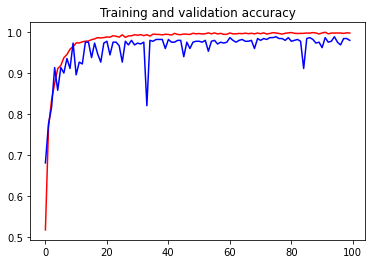

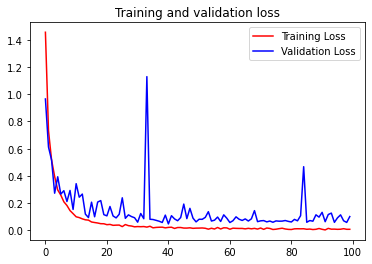

In [46]:
acc = model03.history['accuracy']
val_acc = model03.history['val_accuracy']
loss = model03.history['loss']
val_loss = model03.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(new_val_ds)
predictions = np.array(predictions)

In [48]:
test_predictions = probability_model.predict(new_test_ds)
test_predictions = np.array(test_predictions)

In [49]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  print(f"true_label = { true_label}")

  predicted_label = np.argmax(predictions_array)
  print(f"predicted_label = { predicted_label }")
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  filepath = images[i+beginatimg]
  filepath_arr = filepath.split("/")
  curimage = filepath_arr[3]

  # plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
  #                              100*np.max(predictions_array),
  #                              true_label),
  #                              color=color)
  plt.xlabel("{} {}".format(class_names[predicted_label],
                            curimage), color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [50]:
class_val = {"i" : 0, "ii" : 1, "iii" : 2, "iv" : 3, "v" : 4, "vi" : 5,
             "vii" : 6, "viii" : 7, "ix" : 8, "x" : 9 }

In [51]:
# to store paths of images from folder
validation_images = []
true_labels = []
pred_labels = []
predictions = []
predictions2 = []
scores = []
count = 0;
probability_mode = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
        
for numeral in class_names:
    # path to original images
    images_path=os.path.join(val_dir,numeral) 
    print(images_path)
    for im in os.listdir(images_path):
        validation_images.append(os.path.join(images_path,im))
        
        
        true_labels.append(class_val[numeral])
        cur_image_path = os.path.join(images_path,im)
        img = tf.keras.preprocessing.image.load_img(
            cur_image_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        prediction2 = probability_model.predict(img_array)
        predictions2.append(prediction2)
        prediction = model.predict(img_array)
        # predictions.append(prediction)
        score = tf.nn.softmax(prediction)
        predictions.append(score)
        pred_labels.append(np.argmax(prediction))
print(f"# of validation images: { len(validation_images) }")
print(f"# of true_label: { len(true_labels) }")
print(f"# of pred_label: { len(pred_labels) }")
print(f"# of prediction: { len(predictions) }")

rtdatacentric57/val/i
rtdatacentric57/val/ii
rtdatacentric57/val/iii
rtdatacentric57/val/iv
rtdatacentric57/val/ix
rtdatacentric57/val/v
rtdatacentric57/val/vi
rtdatacentric57/val/vii
rtdatacentric57/val/viii
rtdatacentric57/val/x
# of validation images: 452
# of true_label: 452
# of pred_label: 452
# of prediction: 452


In [52]:
# to store paths of images from folder
test_images = []
test_true_labels = []
test_pred_labels = []
test_predictions = []
test_predictions2 = []
test_scores = []
count = 0;
probability_mode = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
        
for numeral in class_names:
    # path to original images
    images_path=os.path.join(test_dir,numeral) 
    print(images_path)
    for im in os.listdir(images_path):
        test_images.append(os.path.join(images_path,im))
        
        
        test_true_labels.append(class_val[numeral])
        cur_image_path = os.path.join(images_path,im)
        img = tf.keras.preprocessing.image.load_img(
            cur_image_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        test_prediction2 = probability_model.predict(img_array)
        test_predictions2.append(test_prediction2)
        test_prediction = model.predict(img_array)
        # predictions.append(prediction)
        test_score = tf.nn.softmax(test_prediction)
        test_predictions.append(test_score)
        test_pred_labels.append(np.argmax(test_prediction))
print(f"# of test images: { len(test_images) }")
print(f"# of true_label: { len(test_true_labels) }")
print(f"# of pred_label: { len(test_pred_labels) }")
print(f"# of prediction: { len(test_predictions) }")

rtdatacentric57/test/i
rtdatacentric57/test/ii
rtdatacentric57/test/iii
rtdatacentric57/test/iv
rtdatacentric57/test/ix
rtdatacentric57/test/v
rtdatacentric57/test/vi
rtdatacentric57/test/vii
rtdatacentric57/test/viii
rtdatacentric57/test/x
# of test images: 52
# of true_label: 52
# of pred_label: 52
# of prediction: 52


In [53]:
predictions2 = np.array(predictions2)
print(np.argmax(predictions2[200]))
print(true_labels[200])

8
8


In [54]:
test_predictions2 = np.array(test_predictions2)
print(np.argmax(test_predictions2[10]))
print(test_true_labels[10])

2
2


In [55]:
def plot_image(i, predictions_array, true_labels, images, beginatimg):
  # print(f"i = {i} beginatimg = {beginatimg}")
  true_label = true_labels[i] + beginatimg;
  img = tf.keras.preprocessing.image.load_img(
      images[i+beginatimg], target_size=(img_height, img_width)
  )
   
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = img_array / 255.0
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img_array, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  filepath = images[i+beginatimg]
  filepath_arr = filepath.split("/")
  curimage = filepath_arr[3]

  # plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
  #                              100*np.max(predictions_array),
  #                              true_label),
  #                              color=color)
  plt.xlabel("{}".format(curimage), color=color)

def plot_value_array(i, predictions_array, true_labels, beginatimg):
  true_label = true_labels[i+beginatimg]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
    
  predictions_array = np.array(predictions_array)
  predictions1d = predictions_array[0]

  thisplot = plt.bar(range(10), predictions1d, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions1d)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [56]:
numeral_number_images

[]

In [57]:
summary_results = []
test_summary_results = []

In [58]:
import math

In [59]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def show_classifications(rn, startrange ):
  count_arr = np.bincount(true_labels)
  endrange = startrange[rn] + count_arr[rn] 
  # print(f"startrange : {startrange[rn]} endrange : {endrange}")
  # print(f"Number of {class_names[rn]}: {count_arr[rn]}")
  num_rows = math.ceil(count_arr[rn] / 3 )
  num_cols = 3
  num_images = num_rows*num_cols
  num_errors = 0
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    try:
      plot_image(i, predictions2[i+startrange[rn]], true_labels, validation_images, startrange[rn])
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      # print(f" true_labels={true_labels[i]} pred={np.argmax(predictions2[i])}")
      if (true_labels[i+startrange[rn]] != np.argmax(predictions2[i+startrange[rn]])):
        num_errors += 1
      plot_value_array(i, predictions2[i+startrange[rn]],  true_labels, startrange[rn])
    except: 
      print(f"i = {i}")
  plt.tight_layout()
  plt.show()
  print(f"roman numeral: { class_names[rn]}")
  
  print(f"number of images: {count_arr[rn]}")
  print(f"start range: { startrange[rn] }")
  print(f"end range: { startrange[rn] + count_arr[rn]}")
  
  print(f"number of errors: {num_errors}")
  accuracy = 1 - (num_errors / count_arr[rn])
  print(f"accuracy: { accuracy }")

  summary_results.append({'Roman Numeral': class_names[rn], 'Number of Images': count_arr[rn],
                         'Number of Errors': num_errors, 'Accuracy': accuracy})
    

In [60]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def test_show_classifications(rn, startrange ):
  test_count_arr = np.bincount(test_true_labels)
  endrange = startrange[rn] + test_count_arr[rn] 
  # print(f"startrange : {startrange[rn]} endrange : {endrange}")
  # print(f"Number of {class_names[rn]}: {count_arr[rn]}")
  num_rows = math.ceil(test_count_arr[rn] / 3 )
  num_cols = 3
  num_images = num_rows*num_cols
  num_errors = 0
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        try:
            plot_image(i, test_predictions2[i+startrange[rn]], test_true_labels, test_images, startrange[rn])
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            # print(f" true_labels={true_labels[i]} pred={np.argmax(predictions2[i])}")
            if (test_true_labels[i+startrange[rn]] != np.argmax(test_predictions2[i+startrange[rn]])):
                num_errors += 1
            plot_value_array(i, test_predictions2[i+startrange[rn]],  test_true_labels, startrange[rn])
        except:
            print(f"i = {i}")
  plt.tight_layout()
  plt.show()
  print(f"roman numeral: { class_names[rn]}")
  
  print(f"number of images: {test_count_arr[rn]}")
  print(f"start range: { startrange[rn] }")
  print(f"end range: { startrange[rn] + test_count_arr[rn]}")
  
  print(f"number of errors: {num_errors}")
  accuracy = 1 - (num_errors / test_count_arr[rn])
  print(f"accuracy: { accuracy }")

  test_summary_results.append({'Roman Numeral': class_names[rn], 'Number of Images': test_count_arr[rn],
                         'Number of Errors': num_errors, 'Accuracy': accuracy})
    

In [61]:
count_arr = np.bincount(true_labels)
rnindex = 0
beginrange = []
for rnum in range(10):
    beginrange.append(rnindex)
    rnindex = rnindex + count_arr[rnum]


In [62]:
test_count_arr = np.bincount(test_true_labels)
test_rnindex = 0
test_beginrange = []
for rnum in range(10):
    test_beginrange.append(test_rnindex)
    test_rnindex = test_rnindex + test_count_arr[rnum]
   

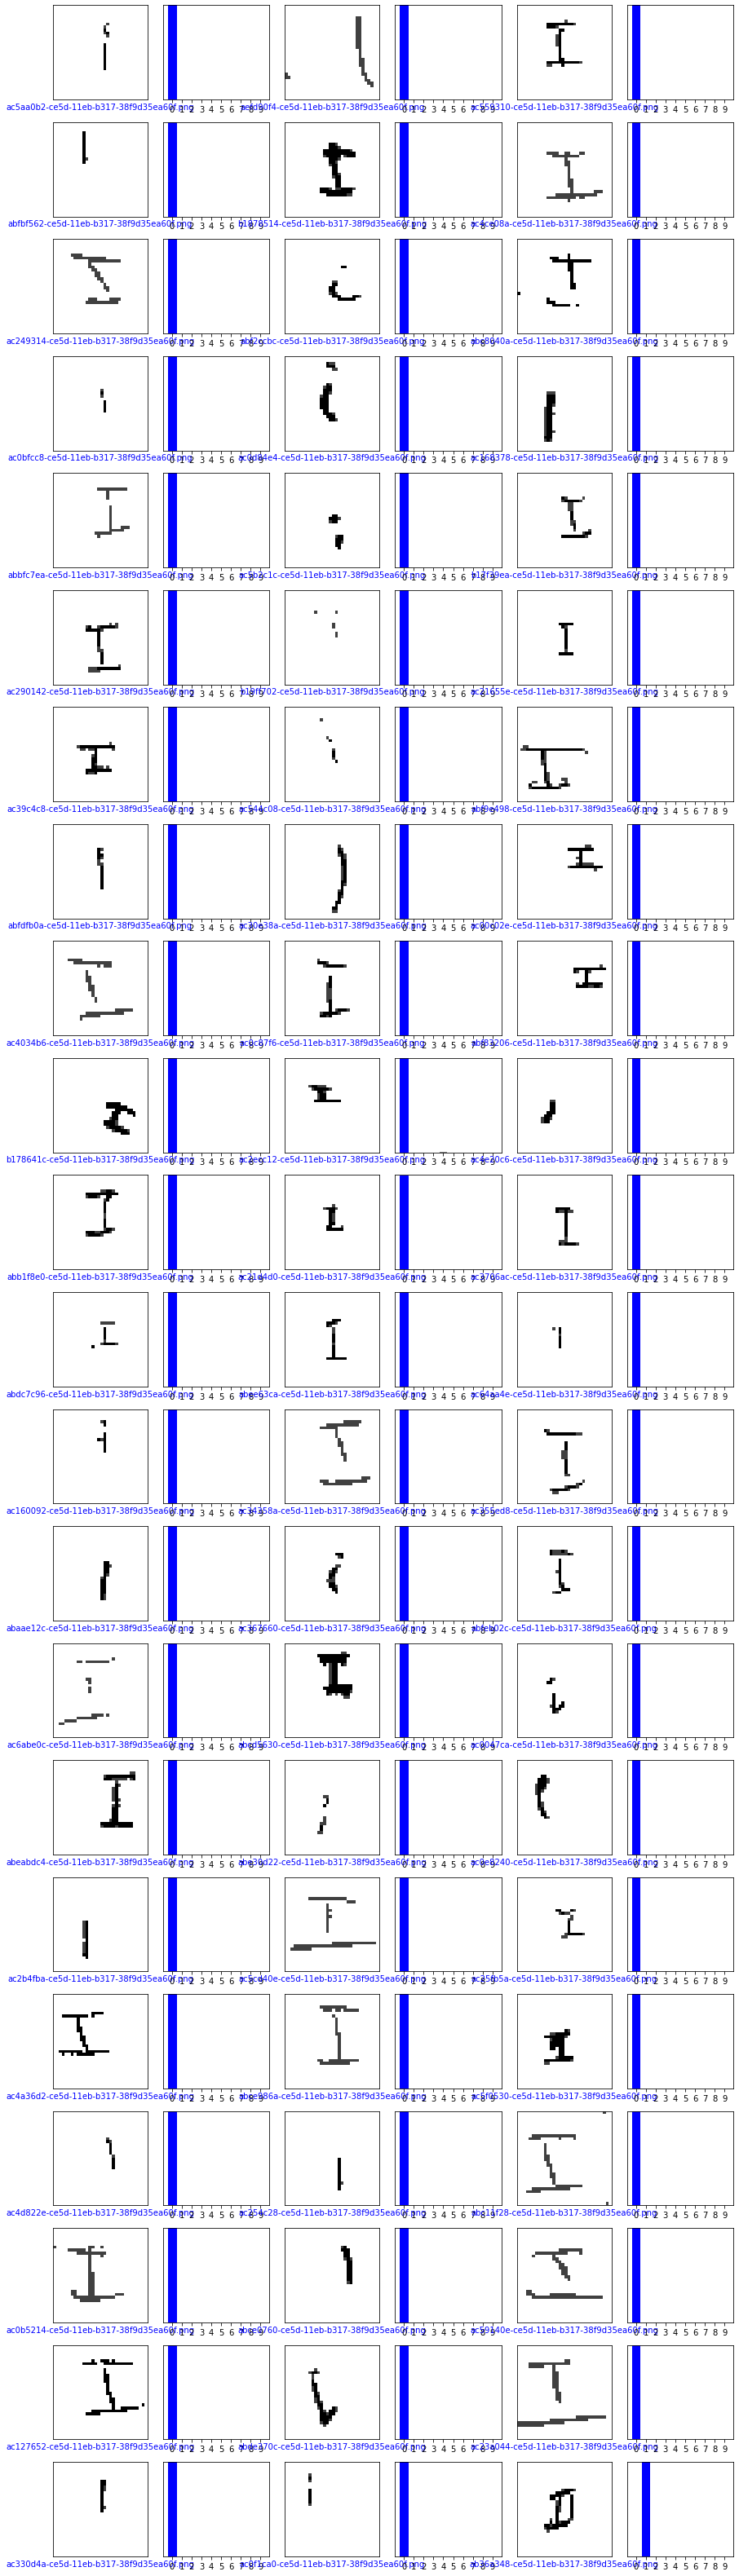

roman numeral: i
number of images: 65
start range: 0
end range: 65
number of errors: 0
accuracy: 1.0


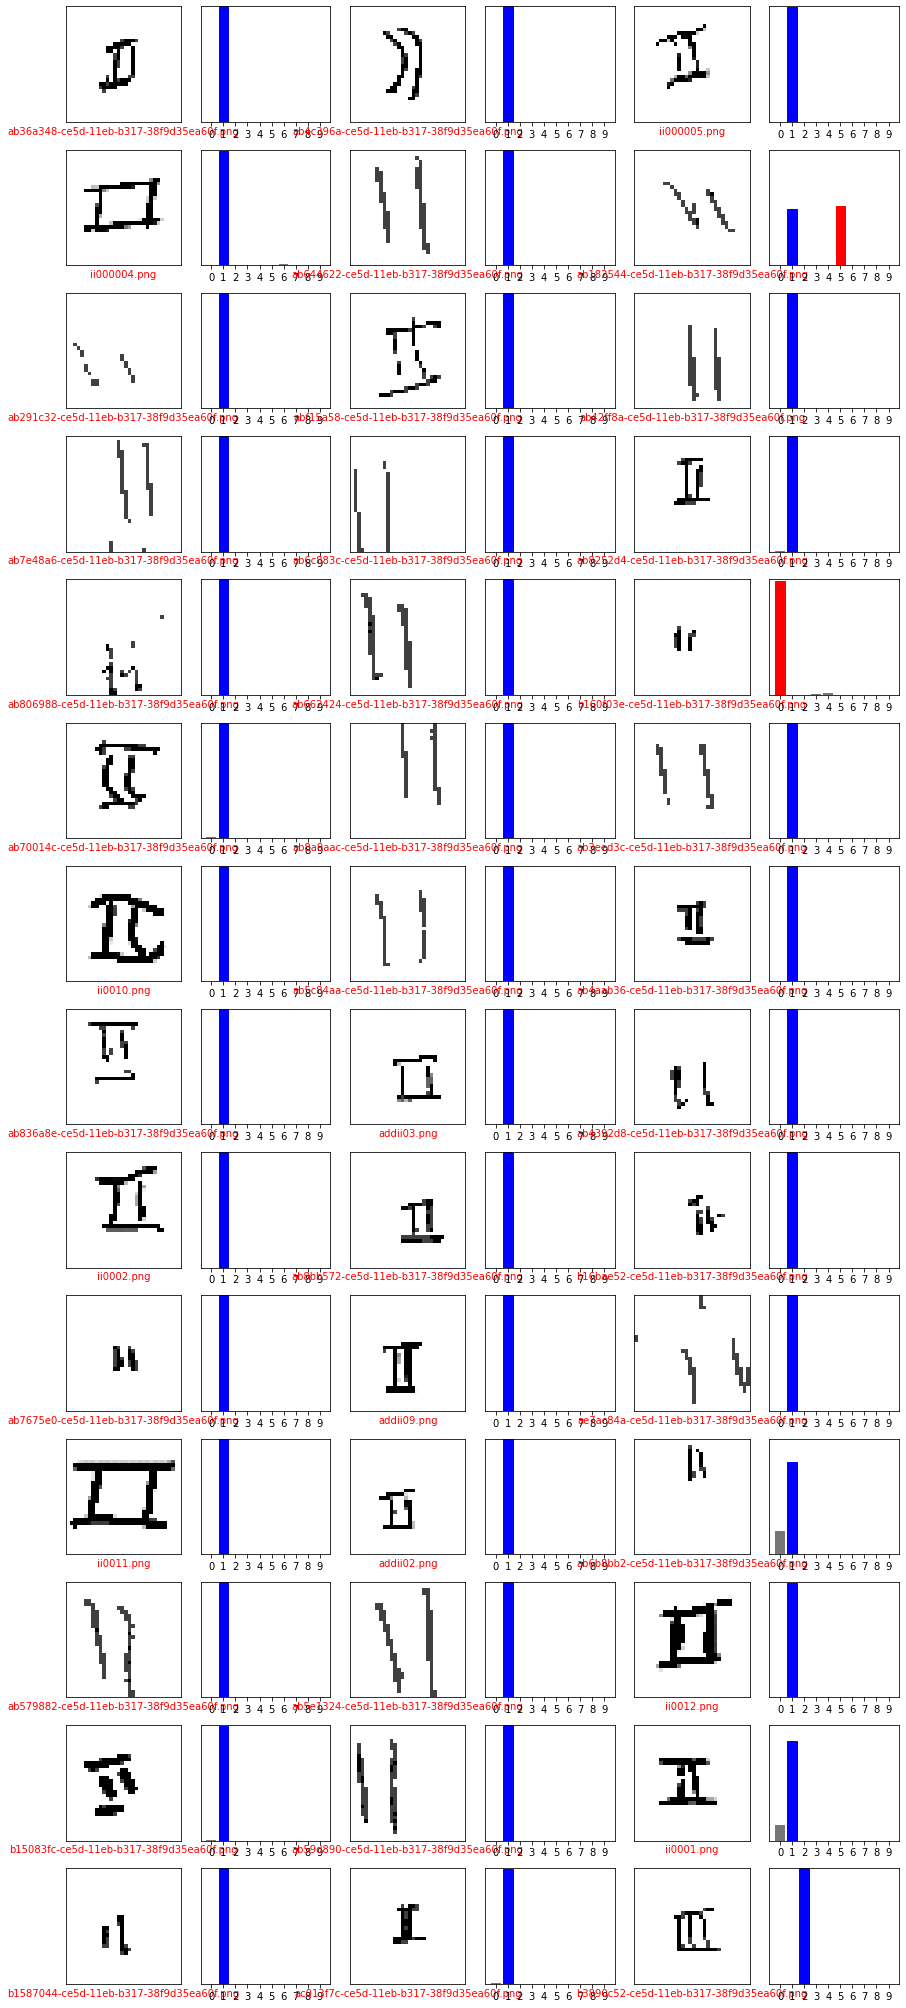

roman numeral: ii
number of images: 41
start range: 65
end range: 106
number of errors: 2
accuracy: 0.9512195121951219


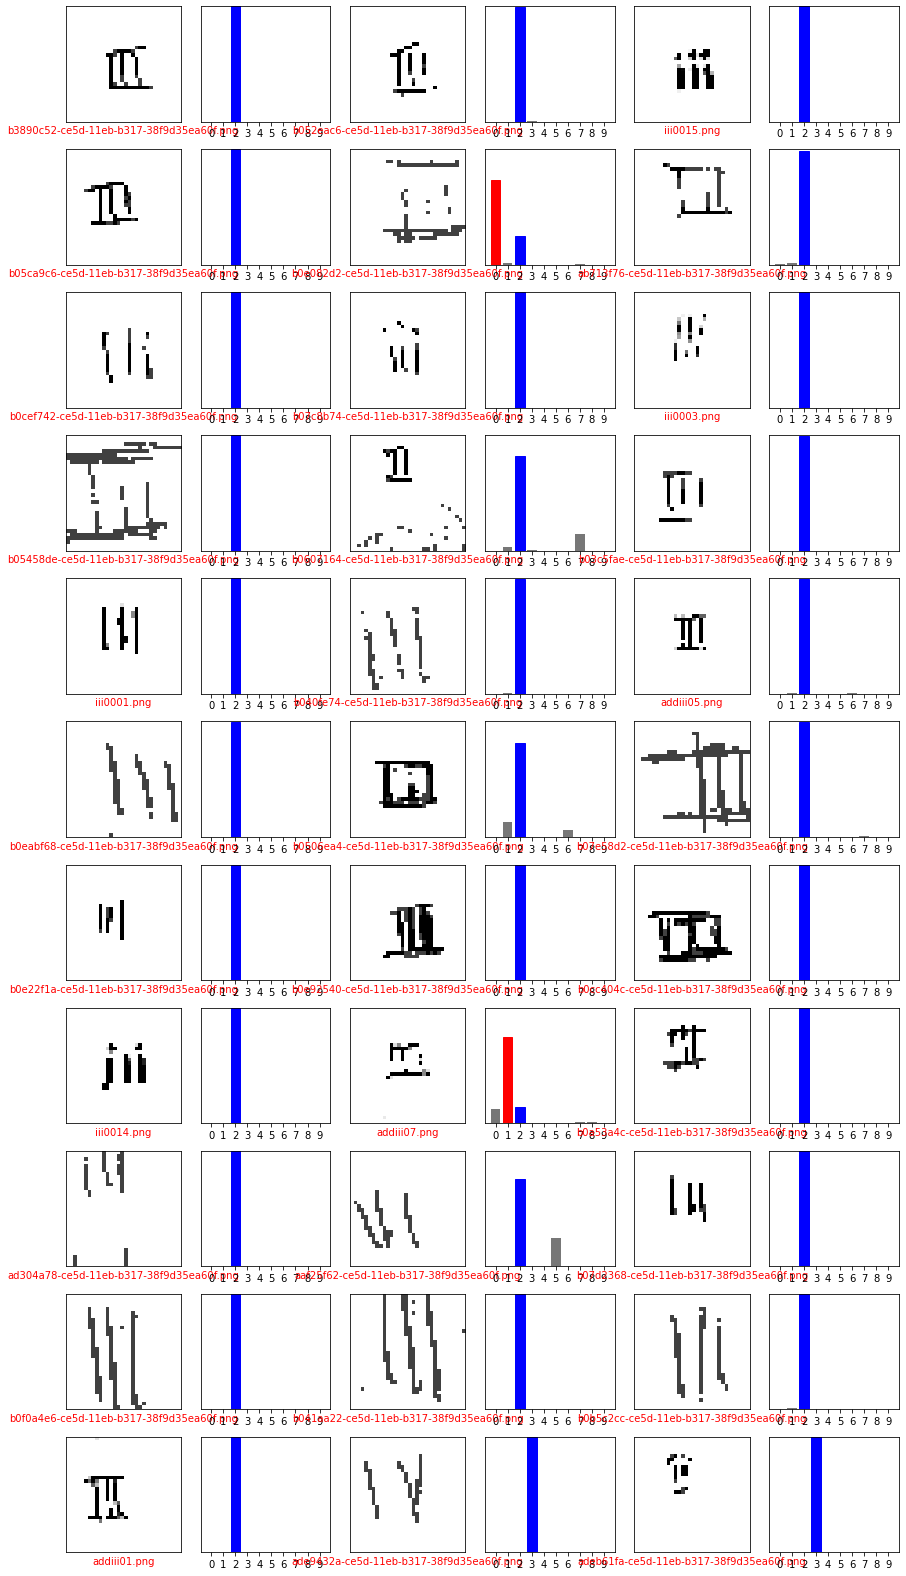

roman numeral: iii
number of images: 31
start range: 106
end range: 137
number of errors: 2
accuracy: 0.935483870967742


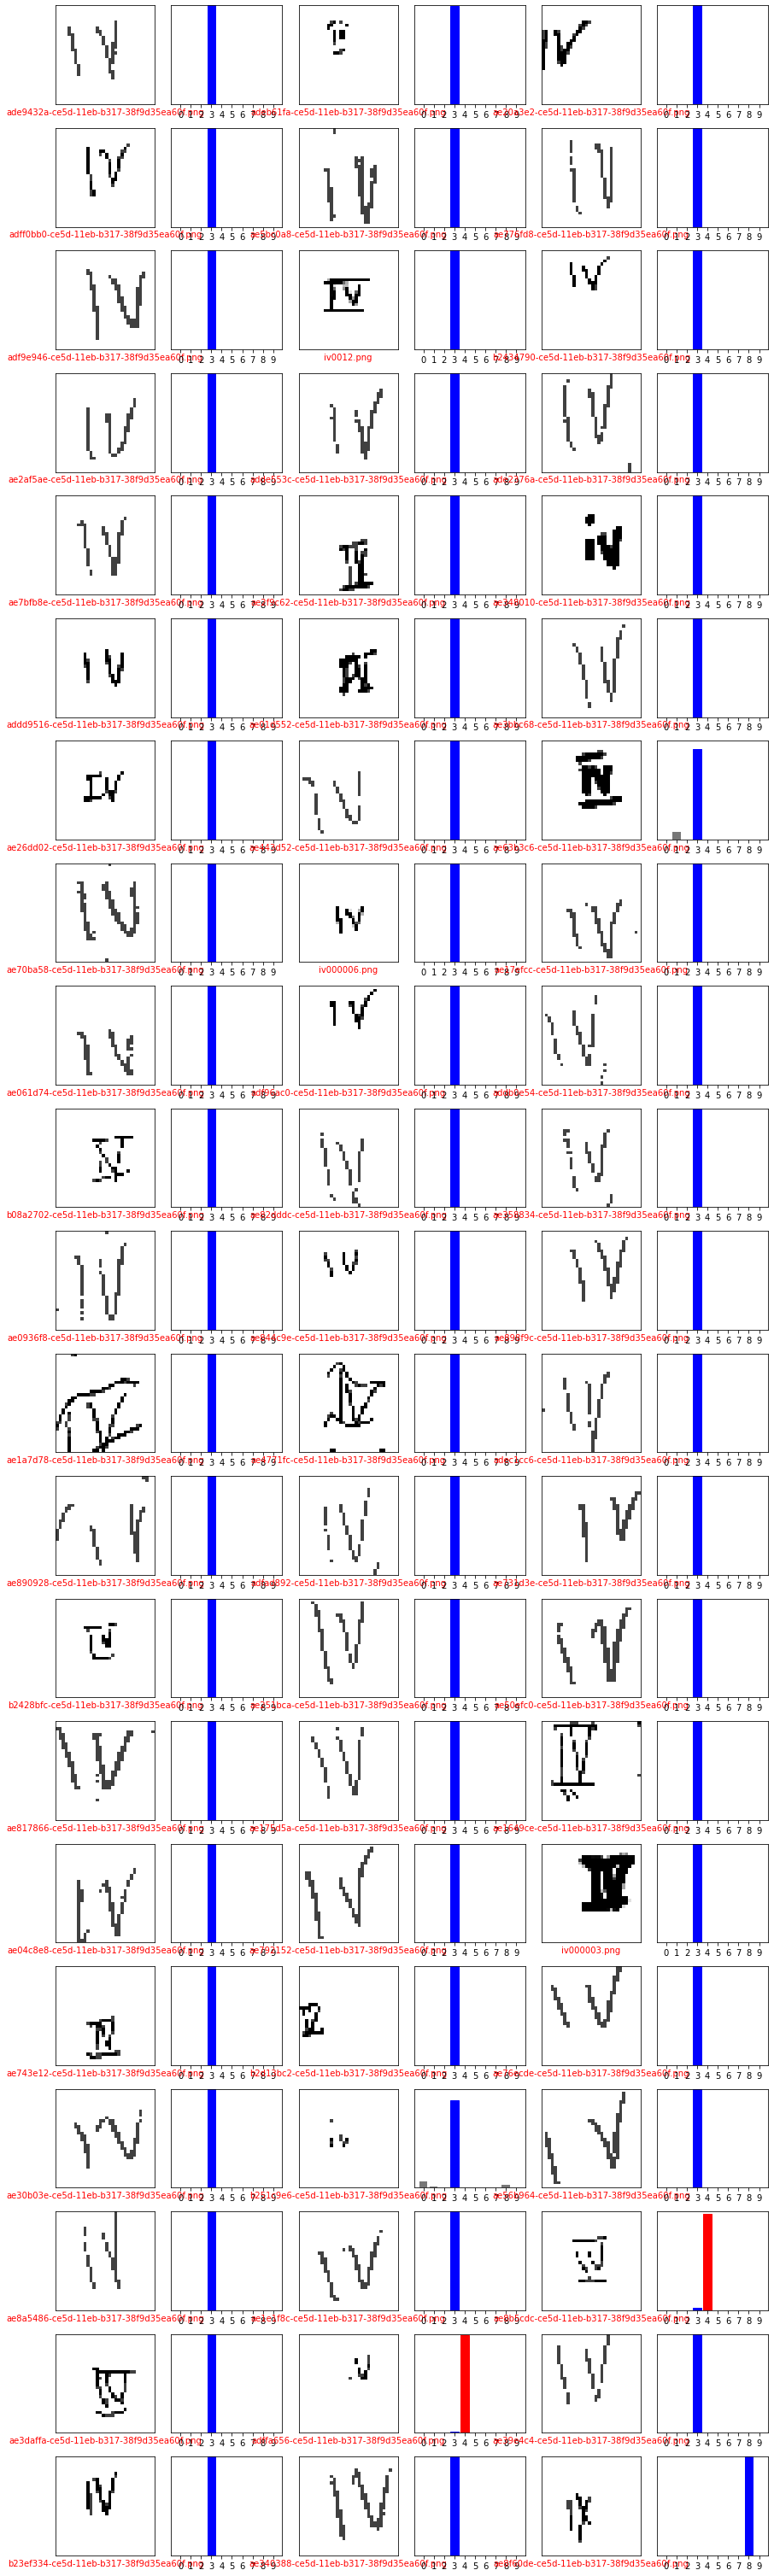

roman numeral: iv
number of images: 62
start range: 137
end range: 199
number of errors: 2
accuracy: 0.967741935483871


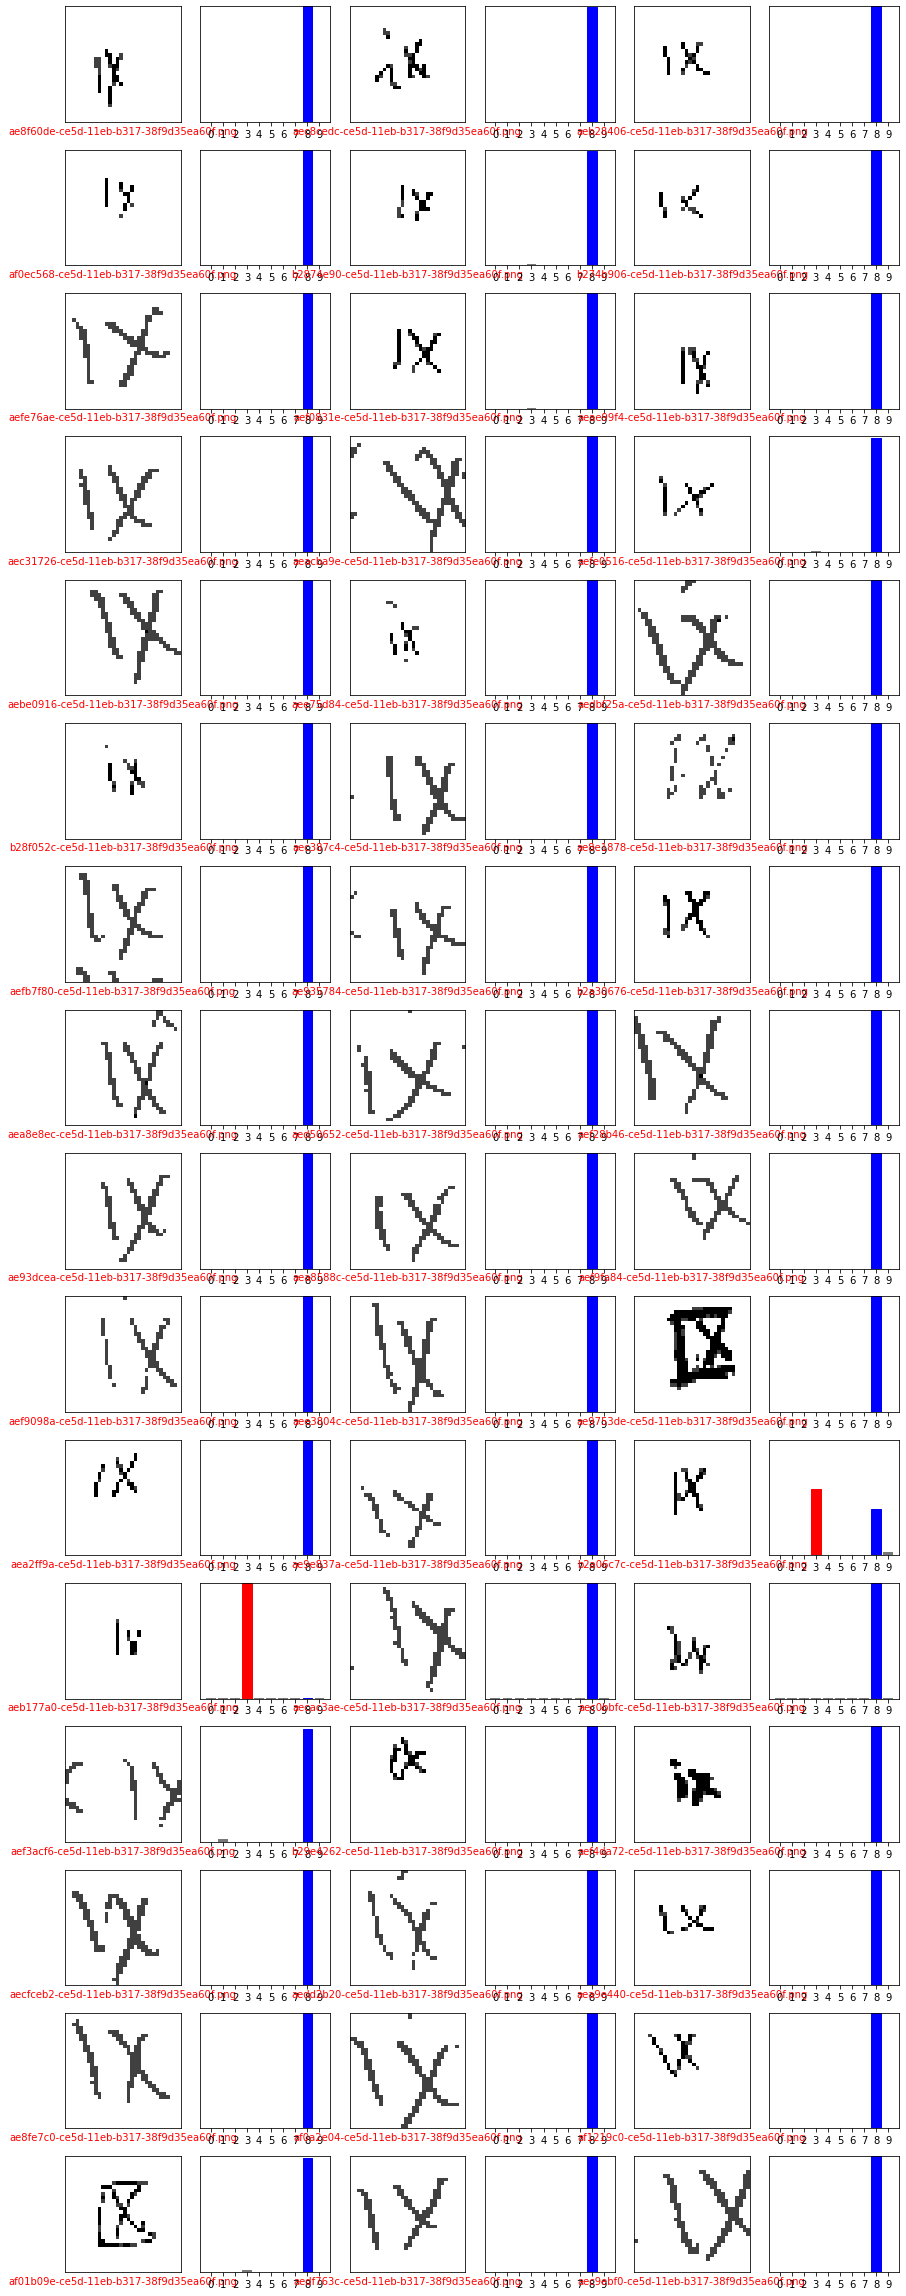

roman numeral: ix
number of images: 48
start range: 199
end range: 247
number of errors: 2
accuracy: 0.9583333333333334


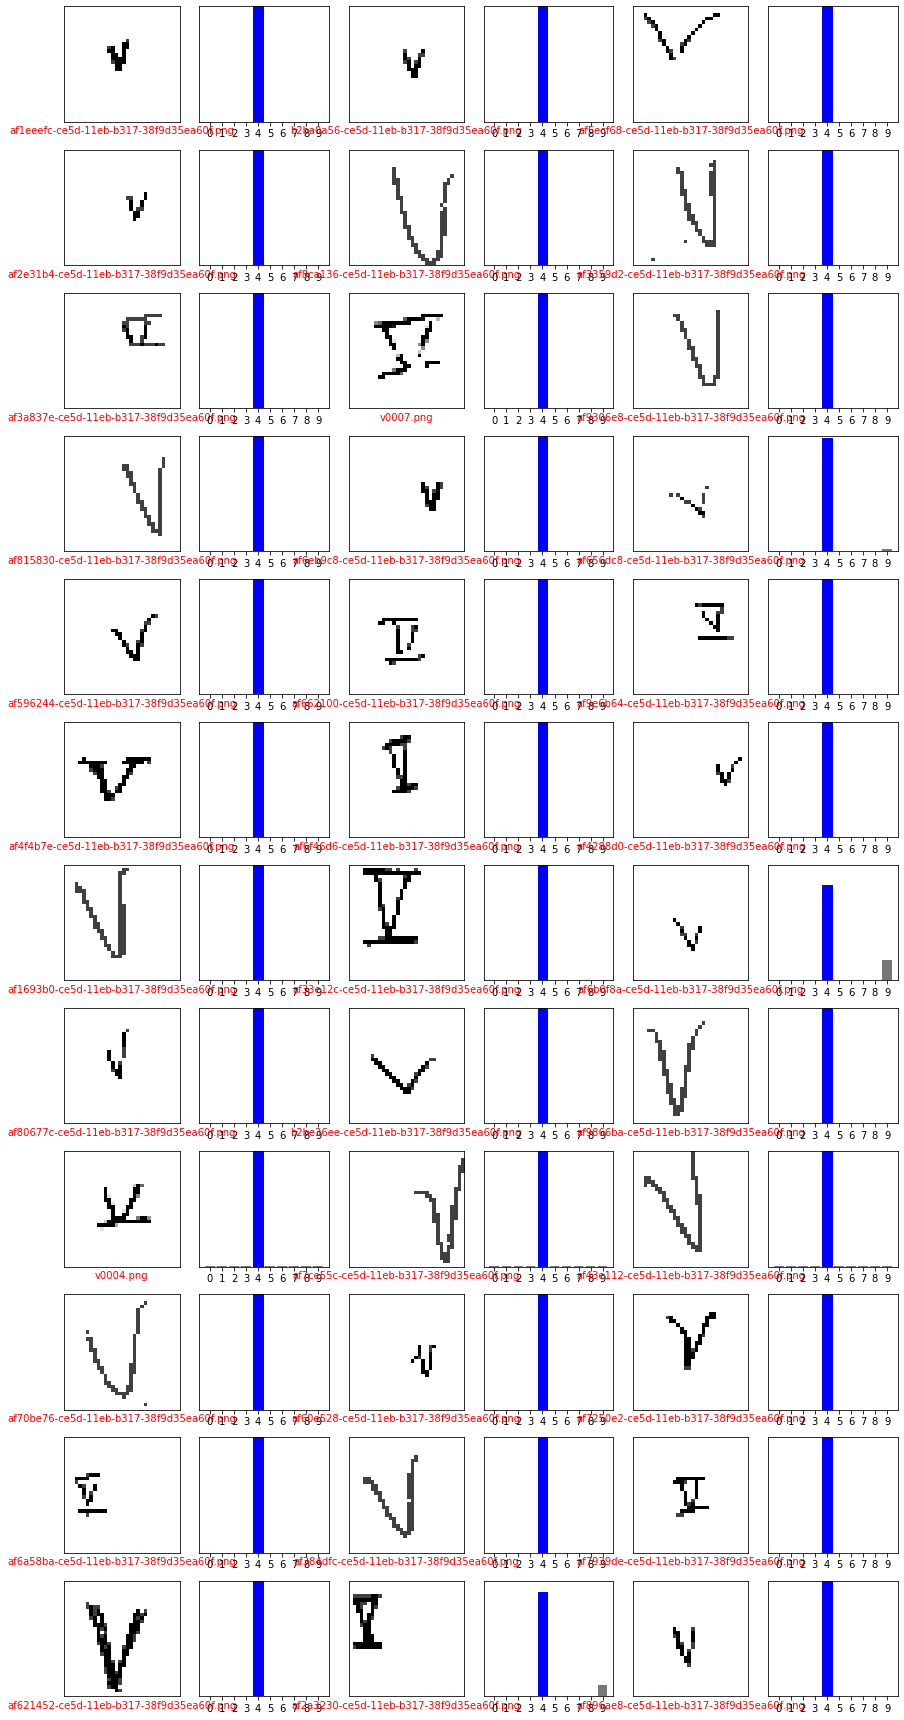

roman numeral: v
number of images: 35
start range: 247
end range: 282
number of errors: 0
accuracy: 1.0


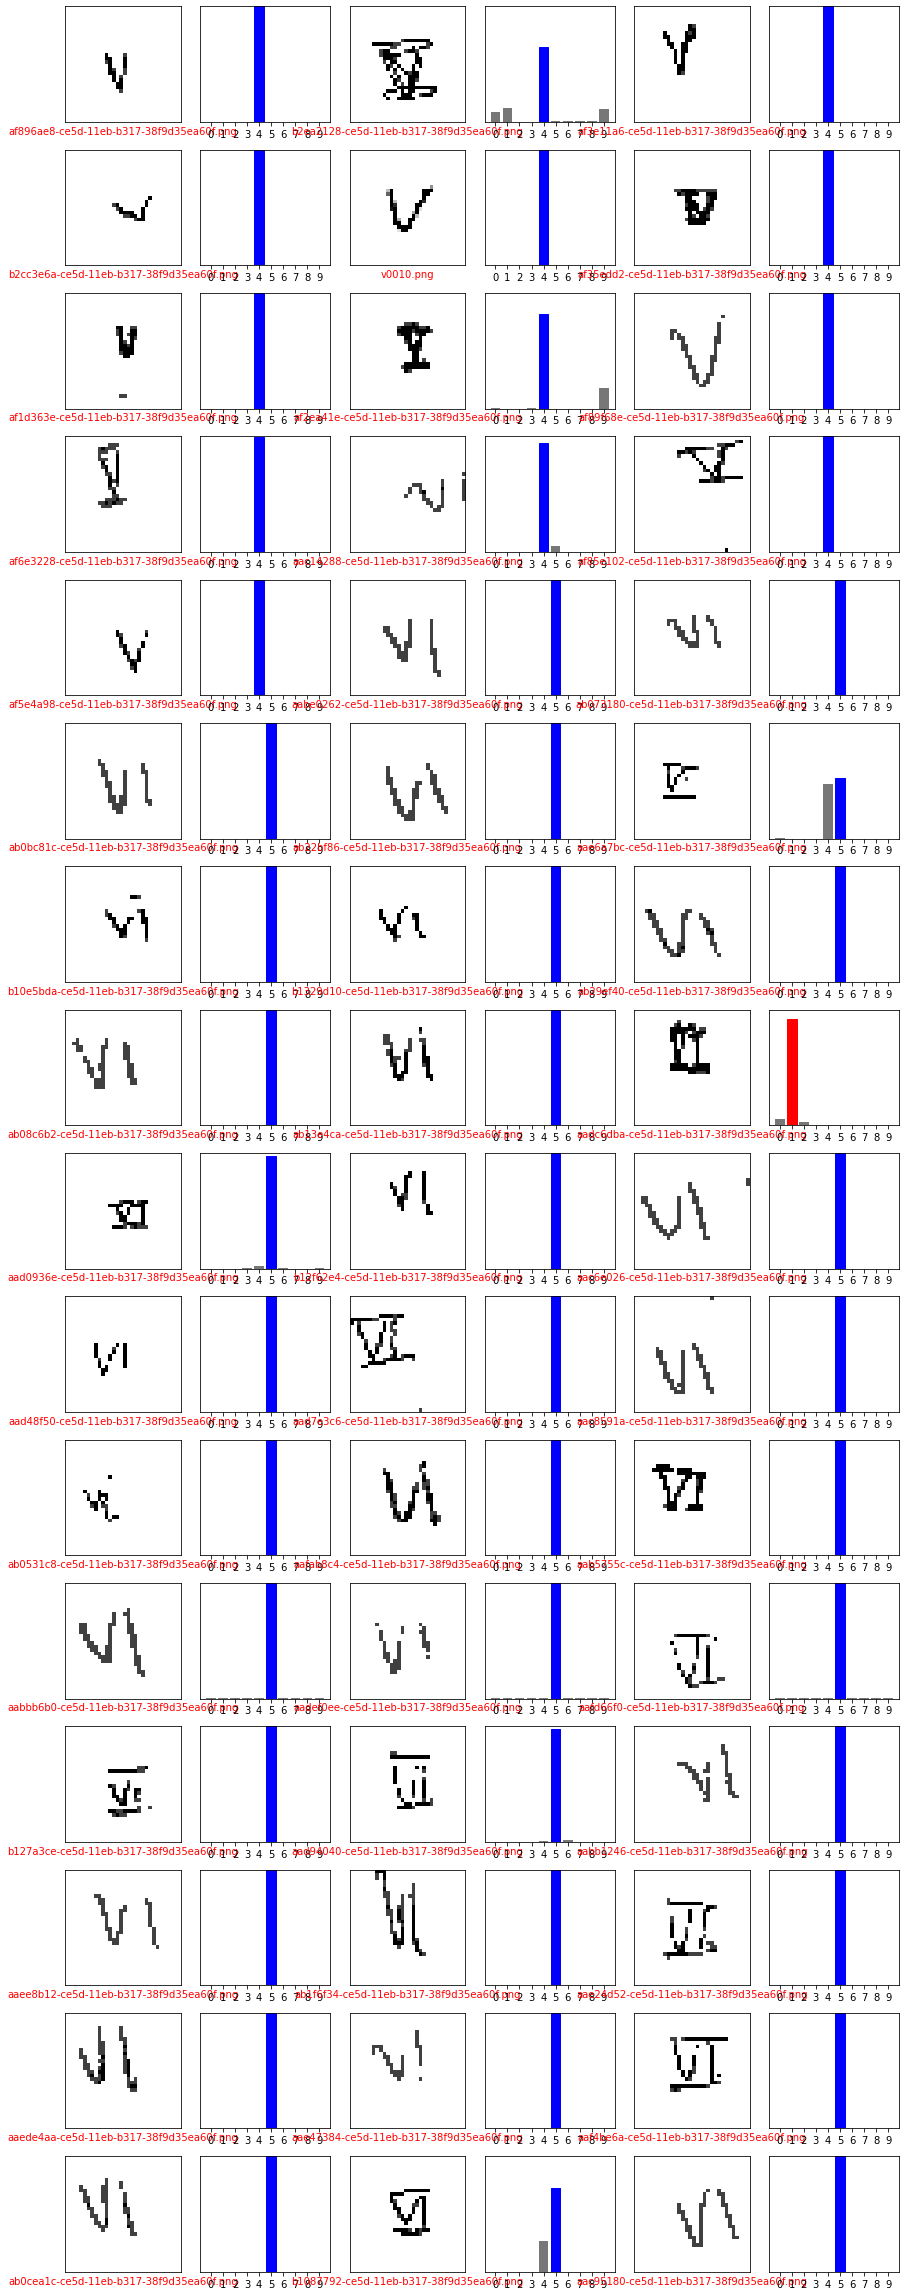

roman numeral: vi
number of images: 48
start range: 282
end range: 330
number of errors: 1
accuracy: 0.9791666666666666


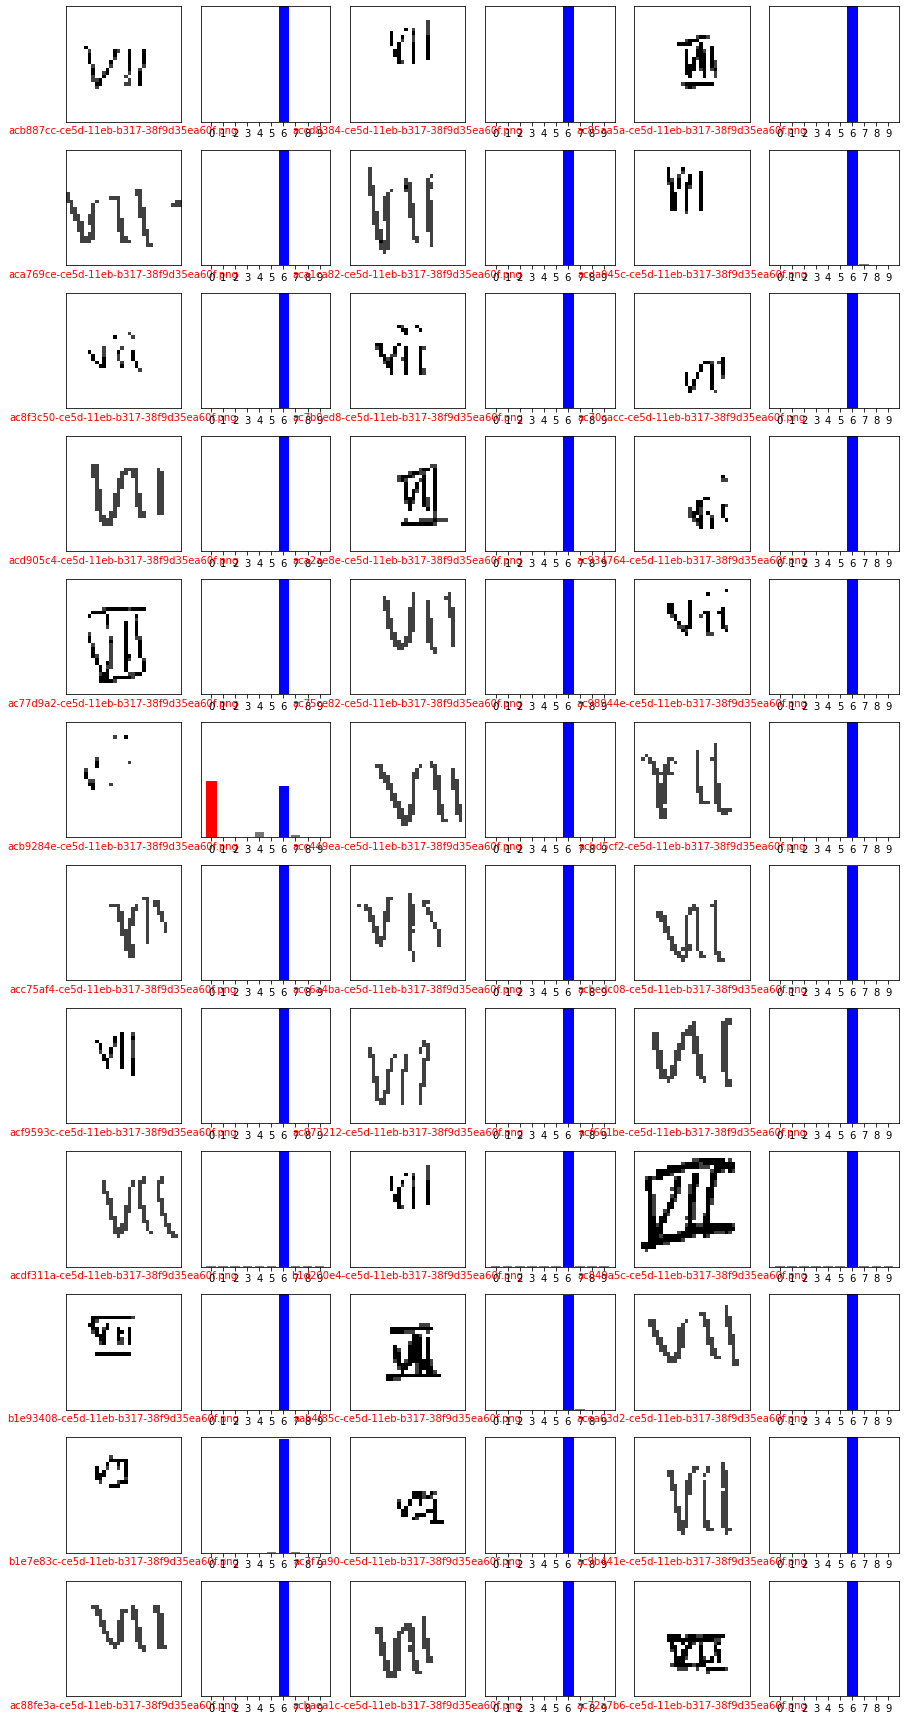

roman numeral: vii
number of images: 35
start range: 330
end range: 365
number of errors: 1
accuracy: 0.9714285714285714


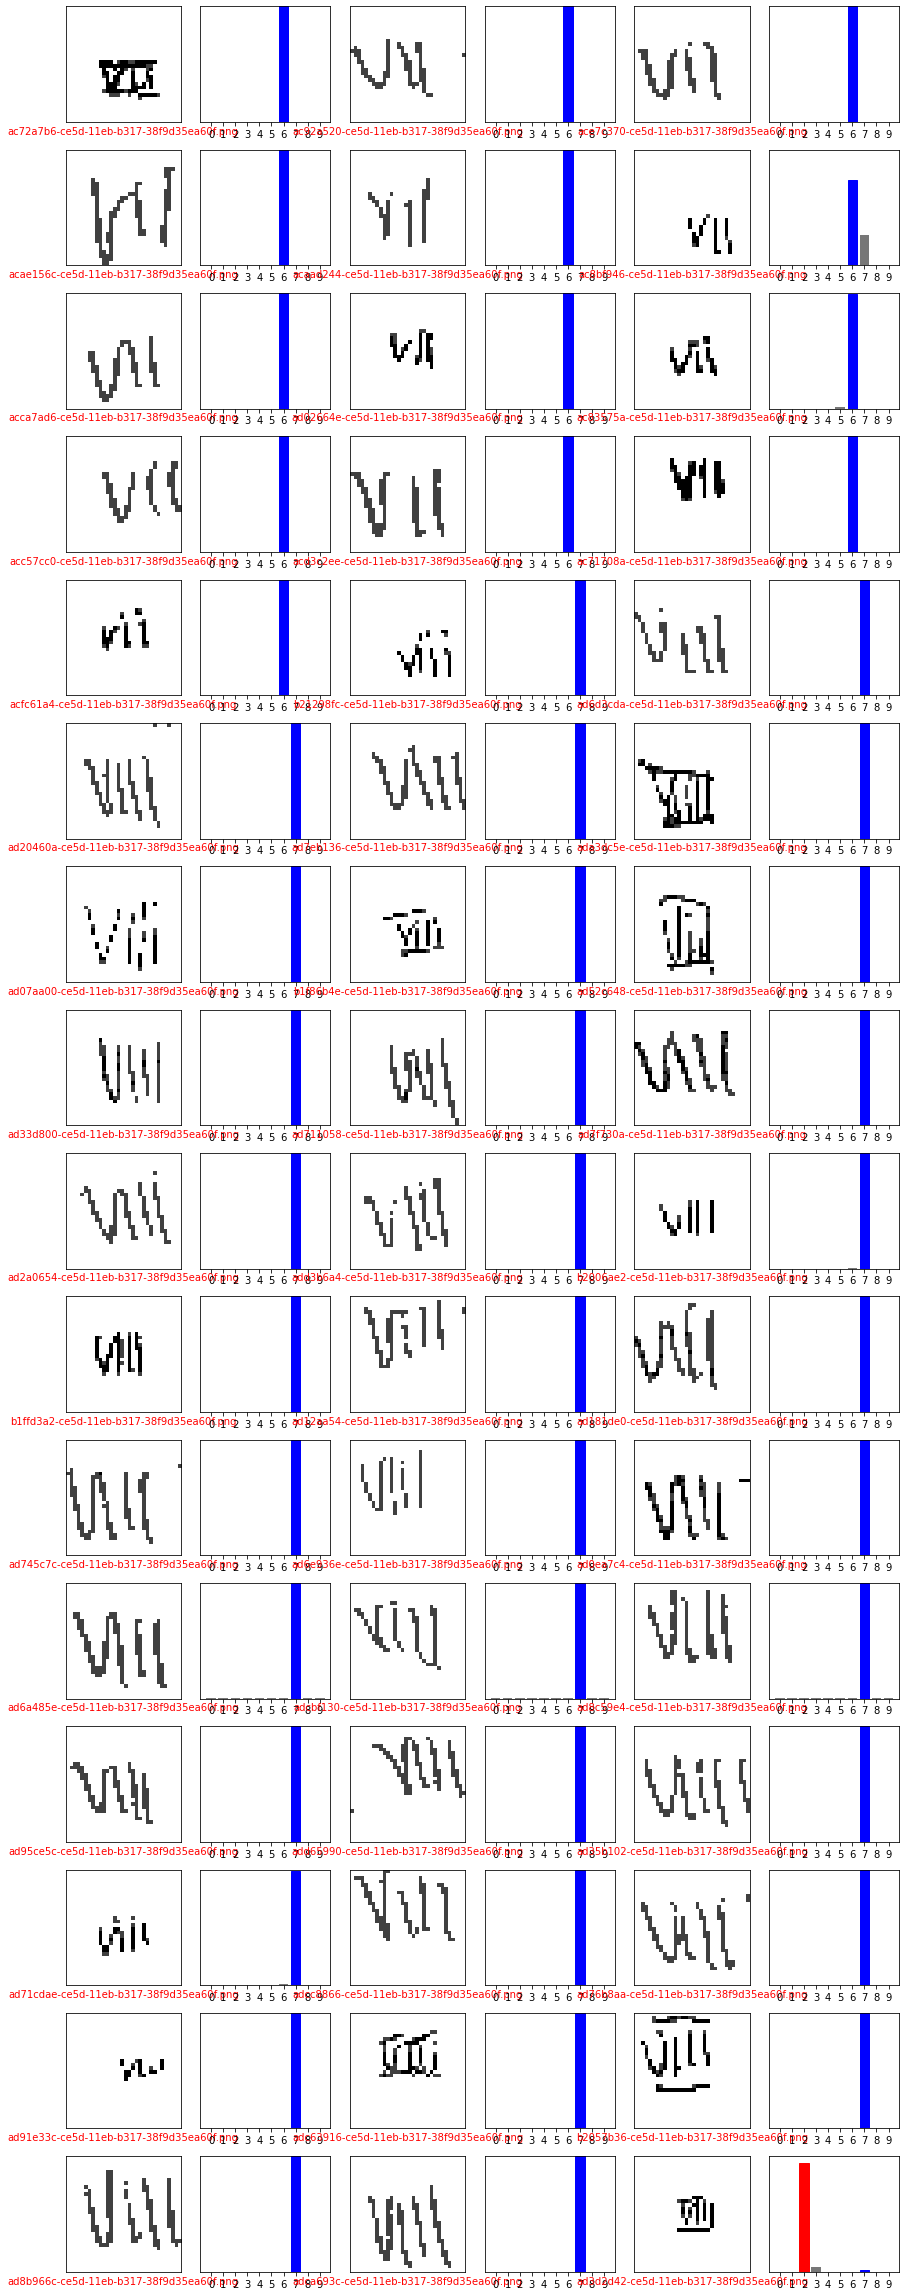

roman numeral: viii
number of images: 48
start range: 365
end range: 413
number of errors: 1
accuracy: 0.9791666666666666


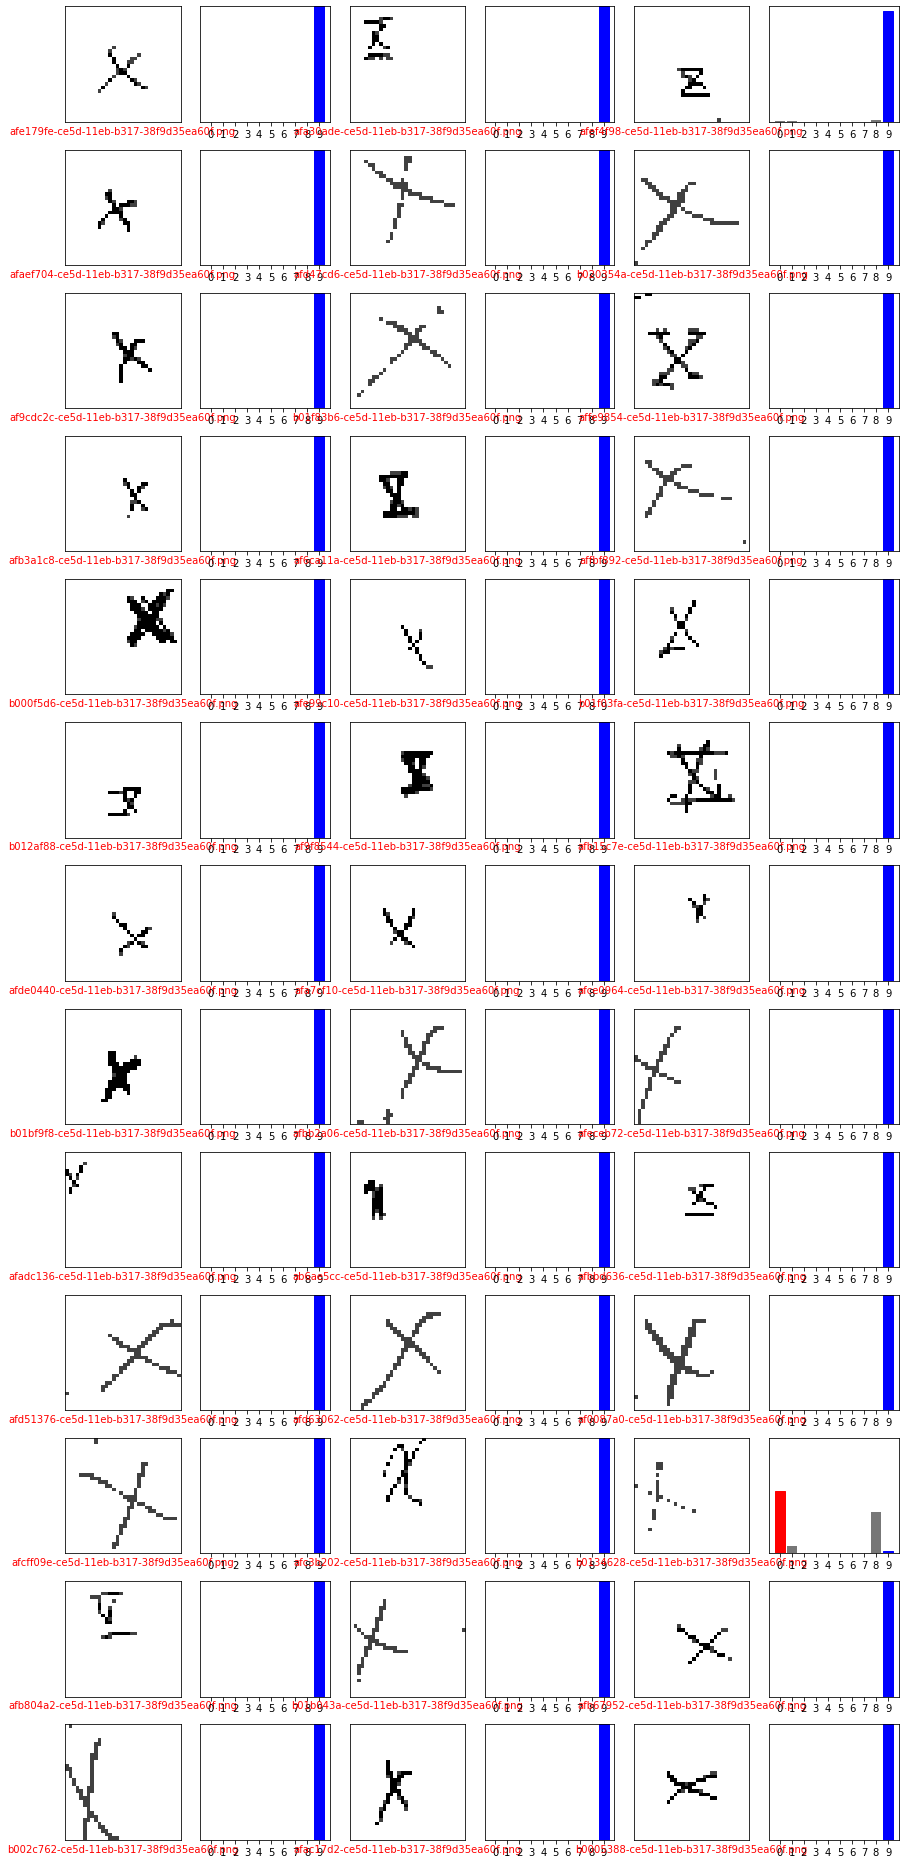

roman numeral: x
number of images: 39
start range: 413
end range: 452
number of errors: 1
accuracy: 0.9743589743589743


In [63]:
for rnum in range(10):
  show_classifications(rnum, beginrange)

In [64]:
summary_results

[{'Roman Numeral': 'i',
  'Number of Images': 65,
  'Number of Errors': 0,
  'Accuracy': 1.0},
 {'Roman Numeral': 'ii',
  'Number of Images': 41,
  'Number of Errors': 2,
  'Accuracy': 0.9512195121951219},
 {'Roman Numeral': 'iii',
  'Number of Images': 31,
  'Number of Errors': 2,
  'Accuracy': 0.935483870967742},
 {'Roman Numeral': 'iv',
  'Number of Images': 62,
  'Number of Errors': 2,
  'Accuracy': 0.967741935483871},
 {'Roman Numeral': 'ix',
  'Number of Images': 48,
  'Number of Errors': 2,
  'Accuracy': 0.9583333333333334},
 {'Roman Numeral': 'v',
  'Number of Images': 35,
  'Number of Errors': 0,
  'Accuracy': 1.0},
 {'Roman Numeral': 'vi',
  'Number of Images': 48,
  'Number of Errors': 1,
  'Accuracy': 0.9791666666666666},
 {'Roman Numeral': 'vii',
  'Number of Images': 35,
  'Number of Errors': 1,
  'Accuracy': 0.9714285714285714},
 {'Roman Numeral': 'viii',
  'Number of Images': 48,
  'Number of Errors': 1,
  'Accuracy': 0.9791666666666666},
 {'Roman Numeral': 'x',
  'Numb

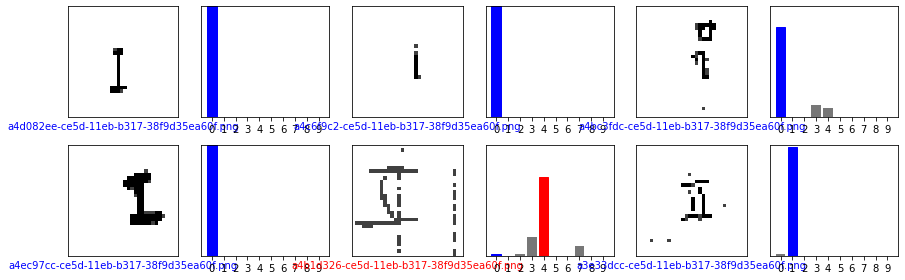

roman numeral: i
number of images: 5
start range: 0
end range: 5
number of errors: 1
accuracy: 0.8


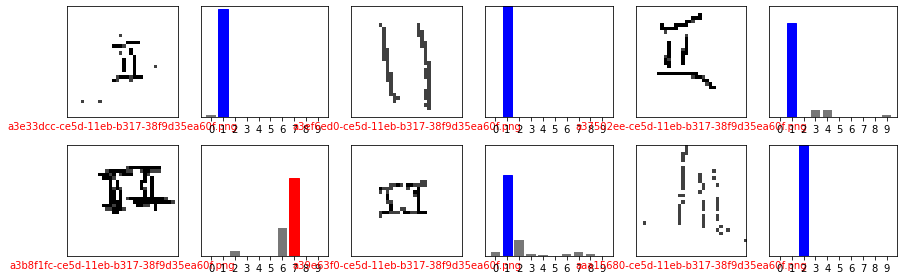

roman numeral: ii
number of images: 5
start range: 5
end range: 10
number of errors: 1
accuracy: 0.8


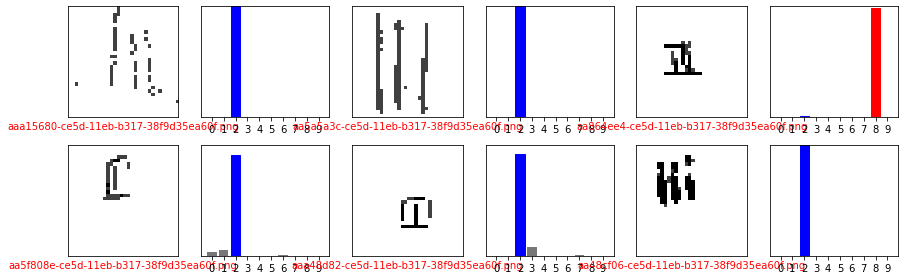

roman numeral: iii
number of images: 6
start range: 10
end range: 16
number of errors: 1
accuracy: 0.8333333333333334


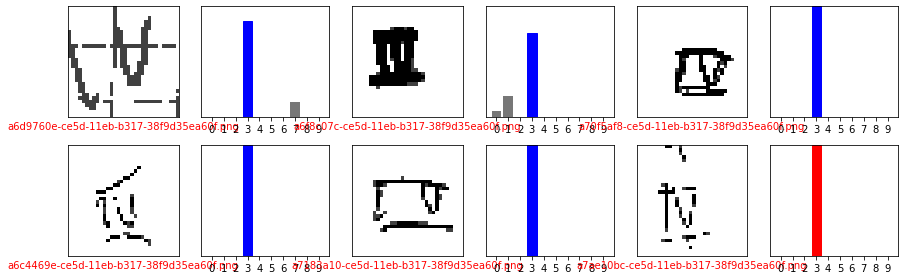

roman numeral: iv
number of images: 5
start range: 16
end range: 21
number of errors: 1
accuracy: 0.8


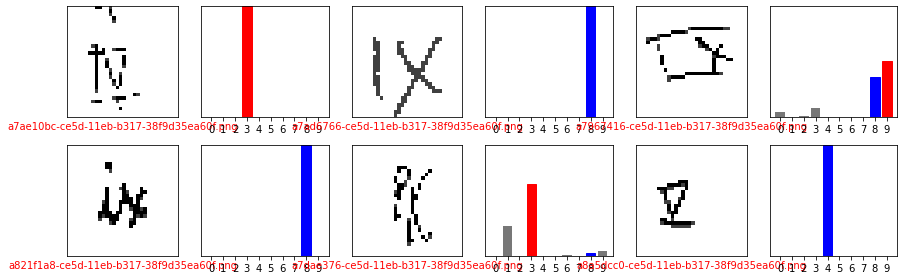

roman numeral: ix
number of images: 6
start range: 21
end range: 27
number of errors: 3
accuracy: 0.5


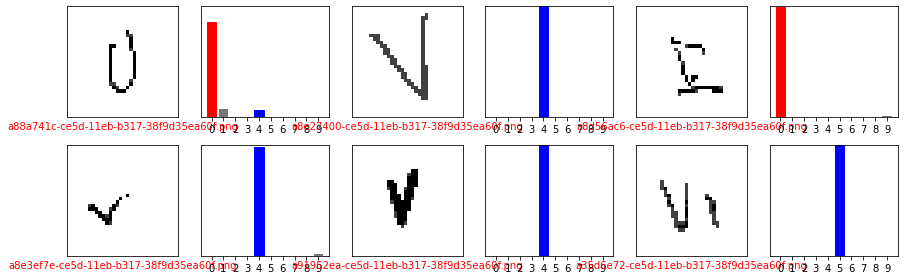

roman numeral: v
number of images: 5
start range: 27
end range: 32
number of errors: 2
accuracy: 0.6


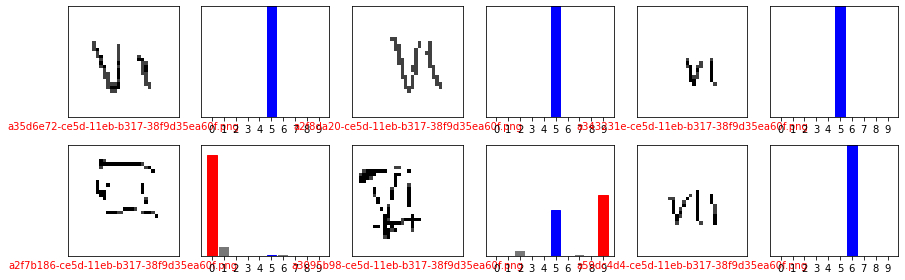

roman numeral: vi
number of images: 5
start range: 32
end range: 37
number of errors: 2
accuracy: 0.6


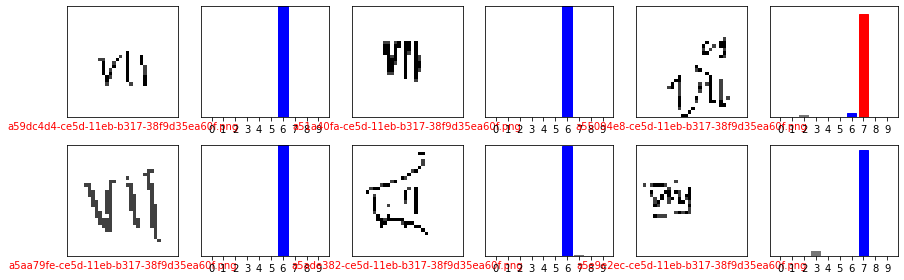

roman numeral: vii
number of images: 5
start range: 37
end range: 42
number of errors: 1
accuracy: 0.8


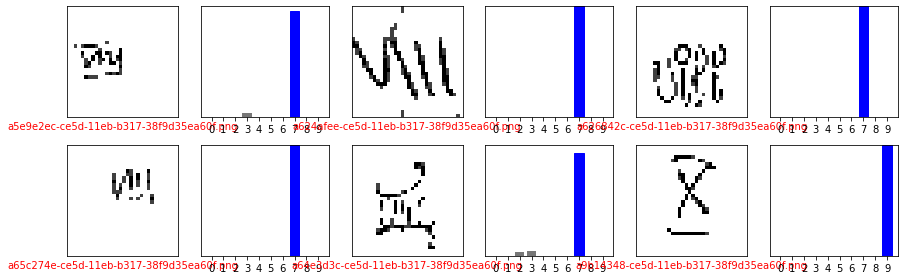

roman numeral: viii
number of images: 5
start range: 42
end range: 47
number of errors: 0
accuracy: 1.0
i = 5


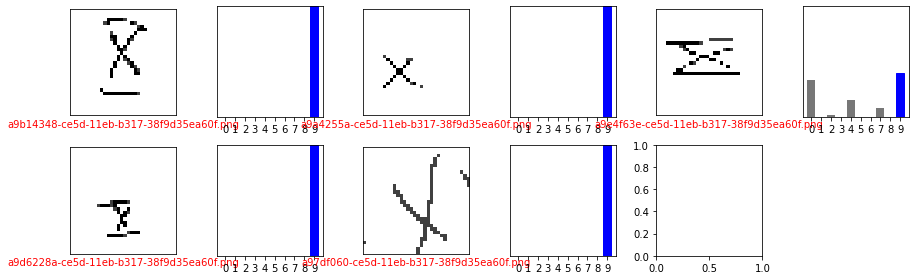

roman numeral: x
number of images: 5
start range: 47
end range: 52
number of errors: 0
accuracy: 1.0


In [65]:

for rnum in range(10):
  test_show_classifications(rnum, test_beginrange)

In [66]:
test_summary_results

[{'Roman Numeral': 'i',
  'Number of Images': 5,
  'Number of Errors': 1,
  'Accuracy': 0.8},
 {'Roman Numeral': 'ii',
  'Number of Images': 5,
  'Number of Errors': 1,
  'Accuracy': 0.8},
 {'Roman Numeral': 'iii',
  'Number of Images': 6,
  'Number of Errors': 1,
  'Accuracy': 0.8333333333333334},
 {'Roman Numeral': 'iv',
  'Number of Images': 5,
  'Number of Errors': 1,
  'Accuracy': 0.8},
 {'Roman Numeral': 'ix',
  'Number of Images': 6,
  'Number of Errors': 3,
  'Accuracy': 0.5},
 {'Roman Numeral': 'v',
  'Number of Images': 5,
  'Number of Errors': 2,
  'Accuracy': 0.6},
 {'Roman Numeral': 'vi',
  'Number of Images': 5,
  'Number of Errors': 2,
  'Accuracy': 0.6},
 {'Roman Numeral': 'vii',
  'Number of Images': 5,
  'Number of Errors': 1,
  'Accuracy': 0.8},
 {'Roman Numeral': 'viii',
  'Number of Images': 5,
  'Number of Errors': 0,
  'Accuracy': 1.0},
 {'Roman Numeral': 'x',
  'Number of Images': 5,
  'Number of Errors': 0,
  'Accuracy': 1.0}]